# Simple protein folding 

$$
U \xrightleftharpoons[k_{-1}]{k_1} I \xrightleftharpoons[k_{-2}]{k_2} F
$$



In [ ]:
import stochastix as stx
import jax
import jax.numpy as jnp
import jax.random as rng
import matplotlib.pyplot as plt

import equinox as eqx

key = jax.random.PRNGKey(42)

jax.config.update('jax_enable_x64', True)
jax.config.update('jax_debug_nans', True)

plt.rcParams['font.size'] = 18

In [ ]:
from stochastix.kinetics import MassAction


## 1. Define Model Parameters as Log-Rates (units: 1/second)
# These values describe a protein folding on a ~10-second timescale.
# This represents a funnel where U -> I is fast, I -> F is favorable, and F is stable.

# Linear rates: k1=1.0, k_minus1=0.05, k2=0.1, k_minus2=0.001
log_k1 = jnp.log(1.0)  # U -> I
log_k_minus1 = float(jnp.log(0.05))  # I -> U
log_k2 = jnp.log(0.1)  # I -> F
log_k_minus2 = float(jnp.log(0.001))  # F -> I


## 2. Create the Reaction Network
# The transform=jnp.exp argument tells MassAction to compute the rate as exp(k)
network = stx.ReactionNetwork(
    [
        # First step: U <--> I
        stx.Reaction('U -> I', MassAction(k=log_k1, transform=jnp.exp), name='U_to_I'),
        stx.Reaction(
            'I -> U', MassAction(k=log_k_minus1, transform=jnp.exp), name='I_to_U'
        ),
        # Second step: I <--> F
        stx.Reaction('I -> F', MassAction(k=log_k2, transform=jnp.exp), name='I_to_F'),
        stx.Reaction(
            'F -> I', MassAction(k=log_k_minus2, transform=jnp.exp), name='F_to_I'
        ),
    ],
)

print(f'Species:\t{network.species}')

## 3. Set up Simulation Models
# Total simulation time, e.g., 10 minutes (600 seconds) to ensure folding completes
T = 120.0

# Initial conditions: start with 1 molecule in the Unfolded state
x0 = jnp.array([0, 0, 1])  # Corresponds to [I, F, U]

# Stochastic model using the Gillespie Direct Method
model = stx.systems.StochasticModel(
    network, stx.DifferentiableDirect(), T=T, max_steps=1000
)

# Mean-field (ODE) model for comparison
model_mf = stx.systems.MeanFieldModel(network, T=T, saveat_steps=1000)

## 4. Convenience functions to recover linear rates from a model instance
k1_fn = lambda m: jnp.exp(m.network.U_to_I.kinetics.k)
k_minus1_fn = lambda m: jnp.exp(m.network.I_to_U.kinetics.k)
k2_fn = lambda m: jnp.exp(m.network.I_to_F.kinetics.k)
k_minus2_fn = lambda m: jnp.exp(m.network.F_to_I.kinetics.k)

Species:	('F', 'I', 'U')


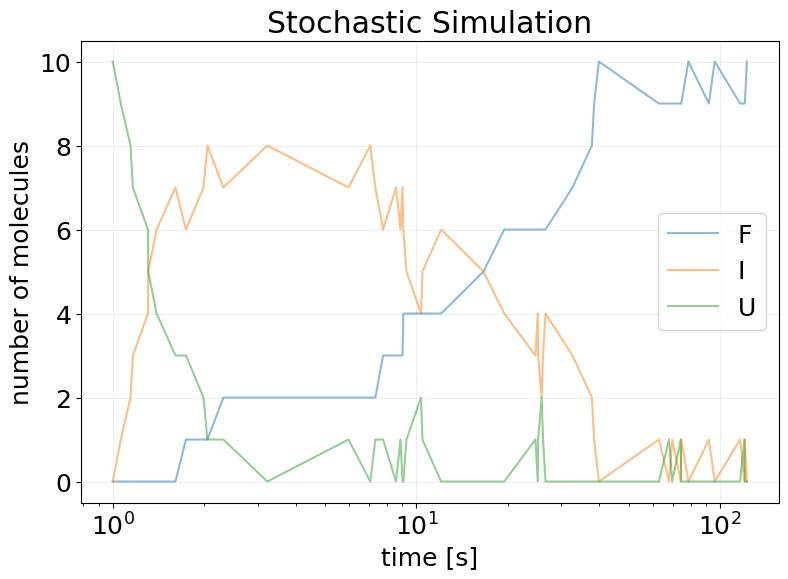

/Users/francesco/Documents/GitHub/jax-ssa/jax_ssa/_simulation_results.py:164: UserWarning: This object does not contain reaction information, returning original object.
  warnings.warn(


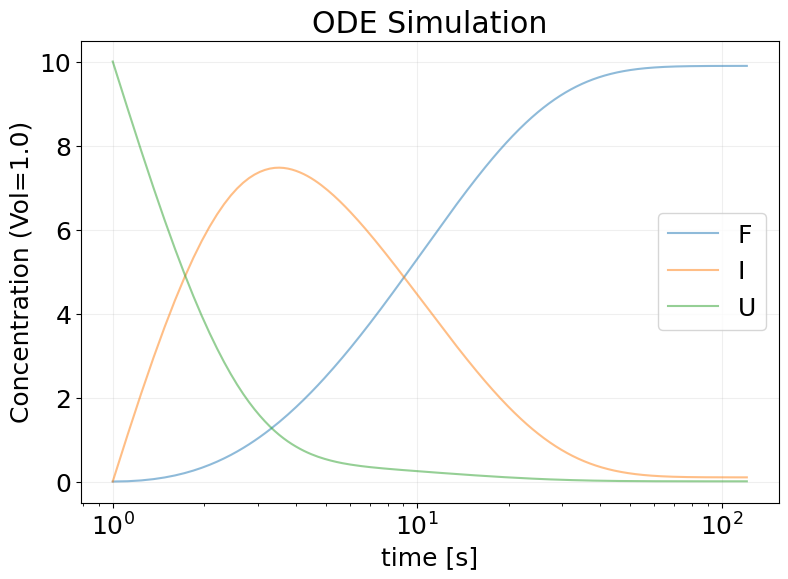

In [ ]:
key, subkey = jax.random.split(key)
sim_results = model(subkey, x0 * 10)

stx.plot_abundance_dynamic(
    eqx.tree_at(lambda x: x.t, sim_results, sim_results.t + 1), log_x_scale=True
)

plt.title('Stochastic Simulation')
plt.show()

mf_results = model_mf(subkey, x0 * 10)

stx.plot_abundance_dynamic(
    eqx.tree_at(lambda x: x.t, mf_results, mf_results.t + 1), log_x_scale=True
)

plt.ylabel(f'Concentration (Vol={network.volume})')

plt.title('ODE Simulation')
plt.show()

In [4]:
sim_results.x

Array([[ 0.,  0., 10.],
       [ 0.,  1.,  9.],
       [ 0.,  2.,  8.],
       ...,
       [10.,  0.,  0.],
       [10.,  0.,  0.],
       [10.,  0.,  0.]], dtype=float64)

## Cost function

In [5]:
def generate_loss(cost_k1=1.0, cost_k2=1.0, stagnation_penalty_kappa=0.1):
    """
    Generates a loss function for the three-state folding model.

    Args:
        cost_k1: The cost coefficient for the U -> I rate (k1).
        cost_k2: The cost coefficient for the I -> F rate (k2).
        stagnation_penalty_kappa: The penalty coefficient for time spent in state I.

    Returns:
        A function that computes the total loss for a given simulation.
    """

    def _loss(model, x0, key):
        # Run a single stochastic simulation from the model's initial state
        sim_results = model(key, x0)

        ## 1. Calculate the Stagnation Cost
        # This is proportional to the SQUARE of the total time spent in state I.

        # Get the population of the intermediate state 'I' during each interval
        I_idx = model.network.species.index('I')
        pop_I = sim_results.x[:-1, I_idx]

        # Get the population of the unfolded state U during each interval
        U_idx = model.network.species.index('U')
        pop_U = sim_results.x[:-1, U_idx]

        # Get the duration of each time step (interval)
        dt = jnp.diff(sim_results.t)

        # Calculate the total integrated time in state I, T_I = integral(pop_I(t) dt)
        total_time_in_I = jnp.sum(pop_I * dt)

        # Calculate the total integrated time in state U, T_U = integral(pop_U(t) dt)
        total_time_in_U = jnp.sum(pop_U * dt)

        # The stagnation cost is (kappa/T) * (T_I)^2
        stagnation_cost = stagnation_penalty_kappa * (total_time_in_I**2) / model.T
        stagnation_cost += stagnation_penalty_kappa * (total_time_in_U**2) / model.T  # noqa

        ## 2. Calculate the Operational Cost
        # This is the linear cost of the "design knob" rates, k1 and k2.

        # Recover the linear rate k1 from the model's log-parameterization
        k1 = model.network.U_to_I.kinetics.k
        k1 = model.network.U_to_I.kinetics.transform(k1)

        # Recover the linear rate k2 from the model's log-parameterization
        k2 = model.network.I_to_F.kinetics.k
        k2 = model.network.I_to_F.kinetics.transform(k2)

        operational_cost = cost_k1 * k1 + cost_k2 * k2

        ## 3. Return the Total Loss
        return operational_cost + stagnation_cost

    return _loss

## Training Function

In [6]:
import equinox as eqx
import optax
from tqdm import tqdm

In [7]:
def train(  # noqa
    key,
    model,
    x0,
    LOSS_FN,
    EPOCHS=20,
    BATCH_SIZE=32,
    LEARNING_RATE=1e-3,
):
    # trick to vmap over named arguments
    loss_and_grads = eqx.filter_value_and_grad(LOSS_FN)
    loss_and_grads = eqx.filter_vmap(loss_and_grads, in_axes=(None, None, 0))

    losses = []

    opt = optax.adam(LEARNING_RATE)
    opt_state = opt.init(eqx.filter(model, eqx.is_array))

    @eqx.filter_jit
    def make_step(model, opt_state, key):
        key, *subkeys = rng.split(key, BATCH_SIZE + 1)
        subkeys = jnp.array(subkeys)

        loss, grads = loss_and_grads(model, x0, subkeys)

        grads = jax.tree.map(lambda x: x.mean(axis=0), grads)

        updates, opt_state = opt.update(grads, opt_state, model)

        model = eqx.apply_updates(model, updates)

        return model, opt_state, loss.mean()

    epoch_subkeys = rng.split(key, EPOCHS)

    pbar = tqdm(epoch_subkeys)
    for epoch_key in pbar:
        try:
            model, opt_state, loss = make_step(model, opt_state, epoch_key)

            losses += [float(loss)]

            pbar.set_description(f'Loss: {loss:.2f}')

        except KeyboardInterrupt:
            print('Training Interrupted')
            break

    log = {'loss': losses}

    return model, log

## Optimize for fixed costs

### Stochastic

In [8]:
cost_k1 = 1.0
cost_k2 = 1.0
stagnation_penalty_kappa = 10.0

loss_fn = generate_loss(
    cost_k1=cost_k1,
    cost_k2=cost_k2,
    stagnation_penalty_kappa=stagnation_penalty_kappa,
)

In [9]:
key, train_key = rng.split(key)

reparam_trained_model, log = train(
    train_key,
    model,
    x0,
    LOSS_FN=loss_fn,
    EPOCHS=300,
    BATCH_SIZE=32,
    LEARNING_RATE=1e-2,
)

Loss: 2.14: 100%|██████████| 300/300 [00:15<00:00, 19.85it/s]


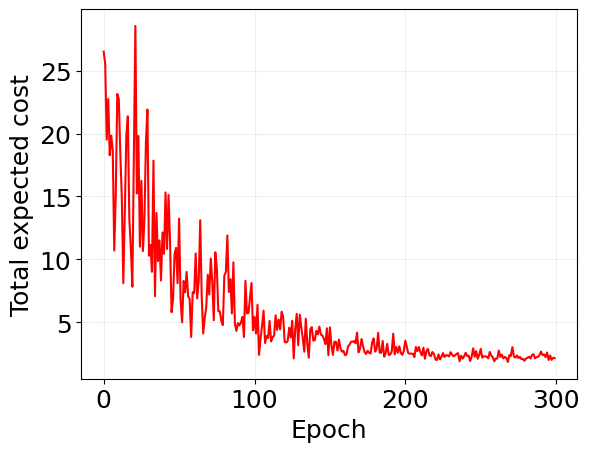

In [10]:
plt.plot(log['loss'], 'r')
plt.xlabel('Epoch')
plt.ylabel('Total expected cost')

plt.grid(alpha=0.2)

In [11]:
k1 = k1_fn(model)
k2 = k2_fn(model)

print(f'Initial k1: {k1:.2f}')
print(f'Initial k2: {k2:.2f}')
print('--------------------------------')

k1_opt = k1_fn(reparam_trained_model)
k2_opt = k2_fn(reparam_trained_model)

print(f'Final k1: {k1_opt:.2f}')
print(f'Final k2: {k2_opt:.2f}')

Initial k1: 1.00
Initial k2: 0.10
--------------------------------
Final k1: 0.73
Final k2: 0.75


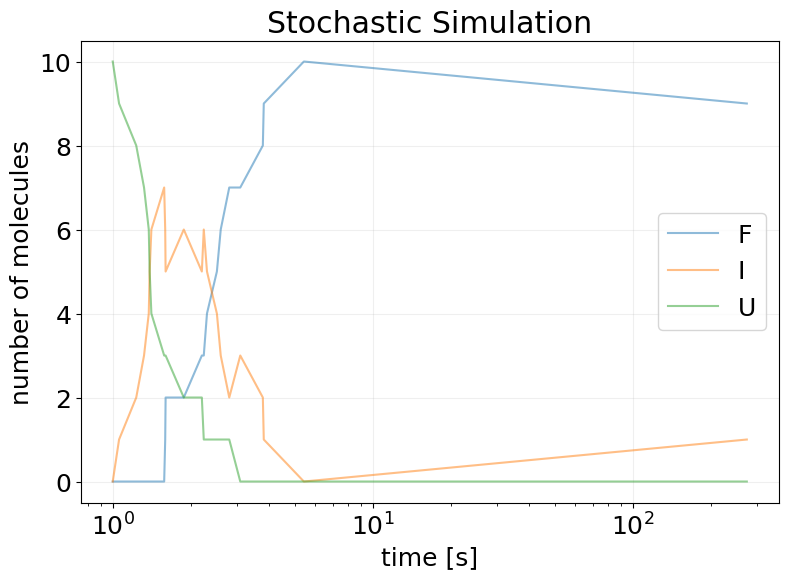

In [ ]:
key, subkey = jax.random.split(key)
sim_results = reparam_trained_model(subkey, x0 * 10)

stx.plot_abundance_dynamic(
    eqx.tree_at(lambda x: x.t, sim_results, sim_results.t + 1), log_x_scale=True
)

plt.title('Stochastic Simulation')
plt.show()

# mf_results = model_mf(subkey, x0*10)

# stx.plot_abundance_dynamic(
#     eqx.tree_at(lambda x: x.t, mf_results, mf_results.t + 1), log_x_scale=True
# )

# plt.ylabel(f'Concentration (Vol={network.volume})')

# plt.title('ODE Simulation')
# plt.show()

### Mean Field

In [13]:
key, train_key = rng.split(key)

mf_trained_model, log_mf = train(
    train_key,
    model_mf,
    x0,
    LOSS_FN=loss_fn,
    EPOCHS=500,
    BATCH_SIZE=1,
    LEARNING_RATE=1e-2,
)

Loss: 1.82: 100%|██████████| 500/500 [00:08<00:00, 60.26it/s] 


In [14]:
k1 = k1_fn(model)
k2 = k2_fn(model)

print(f'Initial k1: {k1:.2f}')
print(f'Initial k2: {k2:.2f}')
print('--------------------------------')

k1_opt = k1_fn(mf_trained_model)
k2_opt = k2_fn(mf_trained_model)

print(f'Final k1: {k1_opt:.2f}')
print(f'Final k2: {k2_opt:.2f}')

Initial k1: 1.00
Initial k2: 0.10
--------------------------------
Final k1: 0.60
Final k2: 0.50


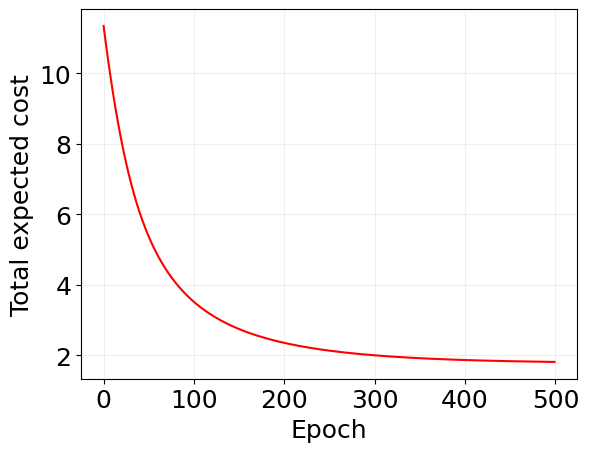

In [15]:
plt.plot(log_mf['loss'], 'r')
plt.xlabel('Epoch')
plt.ylabel('Total expected cost')

plt.grid(alpha=0.2)

In [ ]:
key, *cost_subkeys = jax.random.split(key, 3001)
cost_subkeys = jnp.array(cost_subkeys)

### Init
init_costs = eqx.filter_vmap(loss_fn, in_axes=(None, None, 0))(model, x0, cost_subkeys)

### Opt Stoch
opt_costs = eqx.filter_vmap(loss_fn, in_axes=(None, None, 0))(
    reparam_trained_model, x0, cost_subkeys
)

### Opt ODE
mf_to_stoch_model = stx.StochasticModel(
    mf_trained_model.network,
    stx.DirectMethod(),
    mf_trained_model.T,
    mf_trained_model.max_steps,
)
mf_opt_costs = eqx.filter_vmap(loss_fn, in_axes=(None, None, 0))(
    mf_to_stoch_model, x0, cost_subkeys
)

In [17]:
init_costs.mean(), opt_costs.mean(), mf_opt_costs.mean()

(Array(20.95455734, dtype=float64),
 Array(2.21525593, dtype=float64),
 Array(2.54805691, dtype=float64))

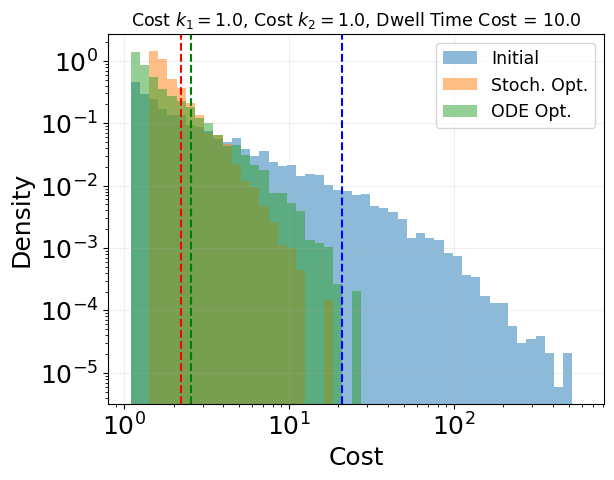

In [18]:
# Create logarithmic bins for better visualization of log-scale data
min_cost = min(jnp.min(init_costs), jnp.min(opt_costs), jnp.min(mf_opt_costs))
max_cost = max(jnp.max(init_costs), jnp.max(opt_costs), jnp.max(mf_opt_costs))
log_bins = jnp.logspace(jnp.log10(min_cost), jnp.log10(max_cost), 50)

plt.hist(init_costs, bins=log_bins, alpha=0.5, label='Initial', density=True)
plt.hist(opt_costs, bins=log_bins, alpha=0.5, label='Stoch. Opt.', density=True)
plt.hist(mf_opt_costs, bins=log_bins, alpha=0.5, label='ODE Opt.', density=True)

plt.grid(alpha=0.2)
plt.legend(fontsize='x-small')

plt.xlabel('Cost')
plt.ylabel('Density')

plt.title(
    f'Cost $k_1 = {cost_k1}$, Cost $k_2 = {cost_k2}$, Dwell Time Cost = {stagnation_penalty_kappa}',
    fontsize='x-small',
)

plt.axvline(jnp.mean(init_costs), color='blue', linestyle='--', label='Initial')
plt.axvline(jnp.mean(opt_costs), color='red', linestyle='--', label='Stoch. Opt.')
plt.axvline(jnp.mean(mf_opt_costs), color='green', linestyle='--', label='ODE Opt.')

plt.xscale('log')
plt.yscale('log')
plt.show()

## Scaling with Dwell Time Cost

In [19]:
dwell_costs = jnp.logspace(-2, 3, 10)

key, train_key = rng.split(key)

In [20]:
### STOCHASTIC SIMULATION
scaling_log = {
    'loss': jnp.zeros_like(dwell_costs),
    'k1': jnp.zeros_like(dwell_costs),
    'k2': jnp.zeros_like(dwell_costs),
    'dwell_cost': dwell_costs,
}


loss_per_cost = []
for i, dwell_cost in enumerate(dwell_costs):
    loss_fn = generate_loss(
        cost_k1=1.0, cost_k2=1.0, stagnation_penalty_kappa=dwell_cost
    )

    trained_model, log = train(
        train_key,
        model,
        x0,
        LOSS_FN=loss_fn,
        EPOCHS=300,
        BATCH_SIZE=48,
        LEARNING_RATE=1e-2,
    )

    loss_per_cost.append(log['loss'])

    scaling_log['loss'] = scaling_log['loss'].at[i].set(log['loss'][-1])
    scaling_log['k1'] = scaling_log['k1'].at[i].set(k1_fn(trained_model))
    scaling_log['k2'] = scaling_log['k2'].at[i].set(k2_fn(trained_model))

Loss: 115.32: 100%|██████████| 300/300 [00:18<00:00, 16.36it/s]


In [21]:
### ODE SIMULATION
mf_scaling_log = {
    'loss': jnp.zeros_like(dwell_costs),
    'k1': jnp.zeros_like(dwell_costs),
    'k2': jnp.zeros_like(dwell_costs),
    'dwell_cost': dwell_costs,
}


mf_loss_per_cost = []
for i, dwell_cost in enumerate(dwell_costs):
    loss_fn = generate_loss(
        cost_k1=1.0, cost_k2=1.0, stagnation_penalty_kappa=dwell_cost
    )

    trained_model, log = train(
        train_key,
        model_mf,
        x0,
        LOSS_FN=loss_fn,
        EPOCHS=300,
        BATCH_SIZE=1,
        LEARNING_RATE=1e-2,
    )

    mf_loss_per_cost.append(log['loss'])

    mf_scaling_log['loss'] = mf_scaling_log['loss'].at[i].set(log['loss'][-1])
    mf_scaling_log['k1'] = mf_scaling_log['k1'].at[i].set(k1_fn(trained_model))
    mf_scaling_log['k2'] = mf_scaling_log['k2'].at[i].set(k2_fn(trained_model))

Loss: 70.01: 100%|██████████| 300/300 [00:03<00:00, 99.13it/s]  


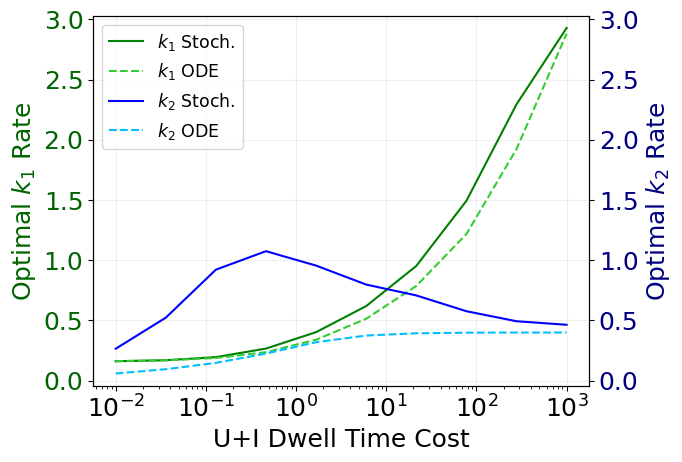

In [30]:
fig, ax1 = plt.subplots()

# Get data ranges to set shared y-axis limits
all_k1_values = jnp.concatenate([scaling_log['k1'], mf_scaling_log['k1']])
all_k2_values = jnp.concatenate([scaling_log['k2'], mf_scaling_log['k2']])
y_min = min(jnp.min(all_k1_values), jnp.min(all_k2_values)) - 0.1
y_max = max(jnp.max(all_k1_values), jnp.max(all_k2_values)) + 0.1

# Plot k1 on left y-axis
ax1.plot(scaling_log['dwell_cost'], scaling_log['k1'], 'g', label='$k_1$ Stoch.')
ax1.plot(
    mf_scaling_log['dwell_cost'],
    mf_scaling_log['k1'],
    'limegreen',
    linestyle='--',
    label='$k_1$ ODE',
)
ax1.set_xscale('log')
ax1.set_xlabel('U+I Dwell Time Cost')
ax1.set_ylabel('Optimal $k_1$ Rate', color='darkgreen')
ax1.tick_params(axis='y', labelcolor='darkgreen')
ax1.set_ylim(y_min, y_max)
ax1.grid(alpha=0.2)

# Create second y-axis for k2 with shared limits
ax2 = ax1.twinx()
ax2.plot(scaling_log['dwell_cost'], scaling_log['k2'], 'b', label='$k_2$ Stoch.')
ax2.plot(
    mf_scaling_log['dwell_cost'],
    mf_scaling_log['k2'],
    'deepskyblue',
    linestyle='--',
    label='$k_2$ ODE',
)
ax2.set_ylabel('Optimal $k_2$ Rate', color='navy')
ax2.tick_params(axis='y', labelcolor='navy')
ax2.set_ylim(y_min, y_max)

# Add common legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize='x-small')